In [11]:
%pip install ultralytics matplotlib opencv-python Pillow tqdm albumentations


Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print("CUDA διαθέσιμη:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU")





CUDA διαθέσιμη: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [1]:
# -*- coding: utf-8 -*-
"""
YOLOv8 Dataset Preparation and Fine-Tuning Script

This script:
1. Reads original NAC bounding-box labels (pixel coords: x1 y1 x2 y2) for 199x199 images.
2. Converts and normalizes labels for both NAC (199x199) and Generated (256x256) images into YOLO format.
3. Splits data into train/val (combined NAC+Generated) and test (separate NAC and Generated).
4. Organizes files into YOLOv8-compatible directory structure.
5. Generates a `dataset.yaml` for training and validation.
6. Fine-tunes a YOLOv8 model and evaluates on NAC and Generated test sets separately.

Requirements:
- Python 3.7+
- ultralytics (YOLOv8)
- scikit-learn
- PyYAML
"""
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import yaml

# 1. User-configurable paths and parameters
orig_img_dir    = Path(r"C:\Users\alexi\Downloads\training_yolo_1_source\NAC")
orig_label_dir  = Path(r"C:\Users\alexi\Downloads\training_yolo_1_source\nac_bb")
gen_img_dir     = Path(r"C:\Users\alexi\Downloads\generated")

# Output directories
proc_label_dir  = Path("processed_labels")
dataset_dir     = Path("dataset_yolo")

# Split ratios
test_ratio_nac  = 0.1   # 10% of NAC for test only
test_ratio_gen  = 0.1   # 10% of Generated for test only
train_ratio     = 0.8
val_ratio       = 0.1

# Image sizes
gorig_size      = (199, 199)
target_nac_size = (256, 256)
target_gen_size = (256, 256)

# Ensure processed labels dirs exist
for subset in ["nac", "gen"]:
    (proc_label_dir / subset).mkdir(parents=True, exist_ok=True)

# 2. Label conversion function

def convert_and_save_label(src_path: Path, dst_path: Path, orig_size: tuple, target_size: tuple):
    """
    Read pixel bbox coords (x1, y1, x2, y2) for an image of size orig_size,
    scale to target_size, convert to YOLO normalized (class 0).
    """
    with src_path.open('r') as f:
        lines = f.read().strip().splitlines()
    if not lines:
        return
    ow, oh = orig_size
    tw, th = target_size
    sx, sy = tw/ow, th/oh
    with dst_path.open('w') as f:
        for line in lines:
            x1, y1, x2, y2 = map(float, line.split())
            # scale coords if needed
            x1_s, y1_s = x1*sx, y1*sy
            x2_s, y2_s = x2*sx, y2*sy
            # YOLO format
            xc = (x1_s + x2_s) / 2.0
            yc = (y1_s + y2_s) / 2.0
            w  = x2_s - x1_s
            h  = y2_s - y1_s
            # normalize
            xc_n = xc / tw
            yc_n = yc / th
            w_n  = w  / tw
            h_n  = h  / th
            f.write(f"0 {xc_n:.6f} {yc_n:.6f} {w_n:.6f} {h_n:.6f}\n")

# 3. Process NAC labels
for img_path in orig_img_dir.glob("*.png"):
    base = img_path.stem
    src_label = orig_label_dir / f"{base}.txt"
    dst_label = proc_label_dir / "nac" / f"{base}.txt"
    if src_label.exists():
        convert_and_save_label(src_label, dst_label, orig_size=gorig_size, target_size=target_nac_size)
    else:
        print(f"Warning: NAC label for {base} not found.")

# 4. Process Generated labels
for img_path in gen_img_dir.glob("*_GEN.png"):
    base_gen = img_path.stem        # e.g. img_1_GEN
    base     = base_gen.replace("_GEN", "")
    src_label = orig_label_dir / f"{base}.txt"
    dst_label = proc_label_dir / "gen" / f"{base_gen}.txt"
    if src_label.exists():
        convert_and_save_label(src_label, dst_label, orig_size=gorig_size, target_size=target_gen_size)
    else:
        print(f"Warning: NAC label for generated {base_gen} not found.")

# 5. Gather image-label pairs
nac_images = list(orig_img_dir.glob("*.png"))
gen_images = list(gen_img_dir.glob("*_GEN.png"))

nac_pairs = [(img, proc_label_dir / "nac" / f"{img.stem}.txt") for img in nac_images]
gen_pairs = [(img, proc_label_dir / "gen" / f"{img.stem}.txt") for img in gen_images]
# Filter only existing labels
nac_pairs = [(i,l) for i,l in nac_pairs if l.exists()]
gen_pairs = [(i,l) for i,l in gen_pairs if l.exists()]

# 6. Split into train/val and test
nac_train_val, nac_test = train_test_split(nac_pairs, test_size=test_ratio_nac, random_state=42)
gen_train_val, gen_test = train_test_split(gen_pairs, test_size=test_ratio_gen, random_state=42)

# Combine for train/val
train_val = nac_train_val + gen_train_val
val_fraction = val_ratio / (train_ratio + val_ratio)
train_pairs, val_pairs = train_test_split(train_val, test_size=val_fraction, random_state=42)

# 7. Create YOLOv8 directory structure
for split in ["train", "val"]:
    (dataset_dir / "images" / split).mkdir(parents=True, exist_ok=True)
    (dataset_dir / "labels" / split).mkdir(parents=True, exist_ok=True)
# test splits
(dataset_dir / "images" / "test" / "nac").mkdir(parents=True, exist_ok=True)
(dataset_dir / "labels" / "test" / "nac").mkdir(parents=True, exist_ok=True)
(dataset_dir / "images" / "test" / "gen").mkdir(parents=True, exist_ok=True)
(dataset_dir / "labels" / "test" / "gen").mkdir(parents=True, exist_ok=True)

# 8. Copy files into structure
def copy_set(pairs, split, prefix=""):
    for img, lbl in pairs:
        out_img = dataset_dir / "images"
        out_lbl = dataset_dir / "labels"
        if split in ["train","val"]:
            out_img = out_img / split / img.name
            out_lbl = out_lbl / split / lbl.name
        else:
            # split is a tuple ("test/nac" or "test/gen")
            kind = split.split('/')[1]
            out_img = out_img / "test" / kind / img.name
            out_lbl = out_lbl / "test" / kind / lbl.name
        shutil.copy(img, out_img)
        shutil.copy(lbl, out_lbl)

copy_set(train_pairs, "train")
copy_set(val_pairs,   "val")
copy_set(nac_test,   "test/nac")
copy_set(gen_test,   "test/gen")

# 9. Write dataset.yaml
with open(dataset_dir / 'dataset.yaml', 'w') as f:
    yaml.dump({
        'path': str(dataset_dir),
        'train': 'images/train',
        'val': 'images/val',
        'nc': 1,
        'names': ['nac']
    }, f)

print("Dataset preparation completed.")

# 10. Fine-tune YOLOv8 and evaluate
try:
    from ultralytics import YOLO
    model = YOLO('yolov8n.pt')
    model.train(
        data=str(dataset_dir / 'dataset.yaml'),
        epochs=50,
        imgsz=256,
        project='runs/train',
        name='exp1'
    )

    # NAC test set evaluation
    nac_test_yaml_path = dataset_dir / 'nac_test.yaml'
    with open(nac_test_yaml_path, 'w') as f:
        yaml.dump({
            'path': str(dataset_dir),
            'train': 'images/train',
            'val': 'images/test/nac',
            'nc': 1,
            'names': ['nac']
        }, f)

    print("Evaluating on NAC test set...")
    model.val(data=str(nac_test_yaml_path), imgsz=256)

    # Generated test set evaluation
    gen_test_yaml_path = dataset_dir / 'gen_test.yaml'
    with open(gen_test_yaml_path, 'w') as f:
        yaml.dump({
            'path': str(dataset_dir),
            'train': 'images/train',
            'val': 'images/test/gen',
            'nc': 1,
            'names': ['nac']
        }, f)

    print("Evaluating on Generated test set...")
    model.val(data=str(gen_test_yaml_path), imgsz=256)

except ImportError:
    print("Please install ultralytics (`pip install ultralytics`) to train.")


Dataset preparation completed.
Ultralytics 8.3.153  Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo\dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp18, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

train: Scanning C:\Users\alexi\dataset_yolo\labels\train.cache... 942 images, 0 backgrounds, 0 corrupt: 100%|██████████


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 2.32.2 MB/s, size: 3.3 KB)


val: Scanning C:\Users\alexi\dataset_yolo\labels\val.cache... 118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11


Plotting labels to runs\train\exp18\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs\train\exp18
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.402G      2.168      2.386      1.157         15        256: 100%|██████████| 59/59 [00:09<00:00,  6.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118    0.00542      0.975     0.0442     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.455G      1.716       1.25       1.01         16        256: 100%|██████████| 59/59 [00:06<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.923      0.607      0.786      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.455G      1.648      1.085      0.978         20        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118       0.86      0.729      0.817      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.455G      1.689      1.015      1.005         19        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.858      0.847      0.874      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.455G      1.556     0.9291     0.9719         21        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.807      0.851      0.853      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.455G       1.53     0.8616     0.9698         25        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.928      0.872      0.922      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.455G      1.511     0.8646     0.9564         14        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.943      0.838      0.907      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.455G      1.471     0.7946     0.9495         17        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.954      0.876      0.941      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.455G      1.432     0.7843       0.95         16        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.913      0.796      0.904      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.455G      1.469     0.7741     0.9407         18        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.919      0.864      0.924      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.455G      1.494     0.7958     0.9474         24        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.845      0.881      0.919      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.455G      1.455     0.7733     0.9508         18        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.892      0.909      0.948      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.455G      1.463     0.7858     0.9533         24        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.956      0.898       0.95       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.455G      1.446     0.7577     0.9424         20        256: 100%|██████████| 59/59 [00:05<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.939      0.898      0.945      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.455G      1.381     0.7238      0.935         21        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.958      0.831      0.927      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.455G      1.372     0.7155     0.9242         22        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118       0.95      0.907      0.963      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.455G      1.313     0.6973     0.9134         18        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.961       0.89      0.946      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.455G      1.343     0.6964      0.915         23        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.924      0.934      0.969      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.455G      1.415     0.7142     0.9422         16        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.963      0.889      0.952      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.455G       1.39     0.7332     0.9361         19        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.974      0.881      0.948      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.455G      1.333     0.6904     0.9279         18        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.946      0.898      0.937      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.455G      1.381     0.7217     0.9342         23        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.918       0.86      0.924      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.455G      1.347     0.6936     0.9181         22        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.959      0.924      0.961      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.455G      1.328     0.6872     0.9122         13        256: 100%|██████████| 59/59 [00:05<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.946      0.899      0.965      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.455G      1.325     0.6892     0.9199         21        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.937      0.886      0.932      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.455G      1.351     0.6867     0.9218         20        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.967      0.864      0.953      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.455G      1.342     0.6906      0.915         24        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.945      0.866      0.943      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.455G       1.32     0.6854     0.9141         16        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.931      0.918      0.952      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.455G      1.291     0.6708     0.9008         16        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.943      0.873      0.937      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.455G       1.29     0.6645     0.9041         22        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.953      0.855      0.929      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.455G        1.3     0.6473     0.9149         24        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.963      0.885      0.942       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.457G      1.303     0.6601     0.9052         23        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.955      0.915      0.961       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.457G      1.255     0.6446     0.9017         18        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.937      0.915      0.952      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.457G      1.241     0.6312     0.8993         20        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.933       0.89      0.957        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.457G      1.285     0.6441     0.8974         23        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118       0.95      0.907      0.951      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.457G      1.259     0.6412     0.9058         20        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.956      0.918      0.962      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.457G      1.249     0.6447     0.9048         18        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118          1      0.922      0.972      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.457G      1.222     0.6164     0.8954         25        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118       0.93      0.895       0.95      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.457G      1.217     0.6161     0.8907         17        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.923      0.898      0.948      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.457G      1.221     0.6225      0.902         17        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.942      0.932      0.949      0.608


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.457G      1.165     0.5918     0.9022         14        256: 100%|██████████| 59/59 [00:05<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.957      0.933      0.974      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.457G      1.131     0.5755     0.8946         14        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.978      0.924      0.972      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.457G      1.124     0.5655     0.8928         14        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.961      0.915      0.967      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.457G      1.109     0.5546     0.8918         14        256: 100%|██████████| 59/59 [00:05<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118       0.97      0.932      0.972      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.457G      1.098     0.5466      0.879         14        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.964       0.92      0.961      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.457G      1.092     0.5474     0.8734         14        256: 100%|██████████| 59/59 [00:05<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.982      0.948      0.978      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.457G      1.079     0.5395     0.8825         14        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.961      0.949      0.977      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.457G      1.065     0.5258     0.8843         14        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.964       0.92      0.965      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.457G      1.081     0.5197     0.8901         14        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.982      0.937      0.976      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.457G      1.083     0.5199     0.8846         14        256: 100%|██████████| 59/59 [00:05<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        118        118      0.981      0.941      0.974      0.654



50 epochs completed in 0.097 hours.
Optimizer stripped from runs\train\exp18\weights\last.pt, 6.2MB
Optimizer stripped from runs\train\exp18\weights\best.pt, 6.2MB

Validating runs\train\exp18\weights\best.pt...
Ultralytics 8.3.153  Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0


                   all        118        118      0.964      0.914      0.965      0.676
Speed: 0.2ms preprocess, 1.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\train\exp18
Evaluating on NAC test set...
Ultralytics 8.3.153  Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2.02.0 MB/s, size: 5.1 KB)


val: Scanning C:\Users\alexi\dataset_yolo\labels\test\nac... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/5

val: New cache created: C:\Users\alexi\dataset_yolo\labels\test\nac.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<0


                   all         59         59      0.914        0.9      0.932      0.622
Speed: 0.7ms preprocess, 5.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\train\exp182
Evaluating on Generated test set...
Ultralytics 8.3.153  Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.10.0 ms, read: 1.51.7 MB/s, size: 2.7 KB)


val: Scanning C:\Users\alexi\dataset_yolo\labels\test\gen... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/5

val: New cache created: C:\Users\alexi\dataset_yolo\labels\test\gen.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<0


                   all         59         59      0.963      0.966      0.991      0.747
Speed: 0.9ms preprocess, 4.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\train\exp183


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Νέα δεδομένα από το τελευταίο run
metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95']

# Αποτελέσματα από validation set (εκπαίδευση)
val_values = [0.964, 0.914, 0.965, 0.676]
# Αποτελέσματα από NAC test set
nac_values = [0.914, 0.900, 0.932, 0.622]
# Αποτελέσματα από Generated test set
gen_values = [0.963, 0.966, 0.991, 0.747]

# Δημιουργία DataFrame
df = pd.DataFrame({
    'Metric': metrics,
    'Train/Val': val_values,
    'NAC Test': nac_values,
    'Generated Test': gen_values
})

# Εμφάνιση πίνακα
import ace_tools as tools; tools.display_dataframe_to_user(name="YOLOv8 Full Metrics Comparison", dataframe=df)

# Δημιουργία γραφήματος
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, df['Train/Val'], width, label='Train/Val')
bars2 = ax.bar(x, df['NAC Test'], width, label='NAC Test')
bars3 = ax.bar(x + width, df['Generated Test'], width, label='Generated Test')

ax.set_ylabel('Metric Value')
ax.set_title('YOLOv8 Metrics Comparison (Train/Val vs NAC vs Generated)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

# Εμφάνιση τιμών πάνω από τις μπάρες
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create DataFrame with the final evaluation metrics
data = {
    'Metric': ['Precision', 'Recall', 'mAP50', 'mAP50-95'],
    'Train/Val': [0.964, 0.914, 0.965, 0.676],
    'NAC Test': [0.914, 0.900, 0.932, 0.622],
    'Generated Test': [0.963, 0.966, 0.991, 0.747]
}
df_metrics = pd.DataFrame(data)

# Calculate percentage difference between Generated and NAC Test
df_metrics['% Difference (Gen - NAC)'] = 100 * (
    df_metrics['Generated Test'] - df_metrics['NAC Test']
) / df_metrics['NAC Test']

# Save comparison metrics to CSV file
csv_path = "comparison_metrics.csv"
df_metrics.to_csv(csv_path, index=False)

# Plot percentage improvements of Generated over NAC Test
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(
    df_metrics['Metric'],
    df_metrics['% Difference (Gen - NAC)']
)
ax.set_title("Percentage Improvement of Generated vs NAC Test")
ax.set_ylabel("Difference (%)")
ax.axhline(0, color='gray', linewidth=0.8)
ax.grid(True, linestyle='--', alpha=0.5)

# Annotate each bar with its corresponding value
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval:.1f}%",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

# Return the CSV path for reference
csv_path

<Figure size 800x500 with 1 Axes>

'comparison_metrics.csv'

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

# Load the trained YOLOv8 model
from ultralytics import YOLO
model_path = "runs/train/exp18/weights/best.pt"
model = YOLO(model_path)

# Directories containing test images
nac_test_dir = Path("dataset_yolo/images/test/nac")
gen_test_dir = Path("dataset_yolo/images/test/gen")

# Select 3 sample images from each set
nac_samples = sorted(glob(str(nac_test_dir / "*.png")))[:3]
gen_samples = sorted(glob(str(gen_test_dir / "*.png")))[:3]

# Function to run predictions and display results
def show_predictions(image_paths, title_prefix):
    fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))
    if len(image_paths) == 1:
        axs = [axs]
    for ax, img_path in zip(axs, image_paths):
        # Run inference on a single image
        results = model(img_path)[0]
        # Load and convert image for plotting
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Draw bounding boxes and confidence scores
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(img, f'{conf:.2f}', (int(x1), int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{title_prefix} Sample")
    plt.suptitle(f"{title_prefix} Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display predictions for NAC and generated images
show_predictions(nac_samples, "NAC")
show_predictions(gen_samples, "Generated")




image 1/1 C:\Users\alexi\dataset_yolo\images\test\nac\img_100.png: 256x256 1 nac, 9.9ms
Speed: 1.5ms preprocess, 9.9ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\nac\img_104.png: 256x256 1 nac, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\nac\img_108.png: 256x256 1 nac, 9.7ms
Speed: 0.8ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 256, 256)


<Figure size 1500x500 with 3 Axes>


image 1/1 C:\Users\alexi\dataset_yolo\images\test\gen\img_102_GEN.png: 256x256 1 nac, 13.5ms
Speed: 0.8ms preprocess, 13.5ms inference, 2.9ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\gen\img_106_GEN.png: 256x256 1 nac, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 2.4ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\gen\img_10_GEN.png: 256x256 1 nac, 10.9ms
Speed: 0.7ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 256, 256)


<Figure size 1500x500 with 3 Axes>

In [6]:
pip install ultralytics


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import pandas as pd
import numpy as np

# Create export directory and subdirectories
export_dir = Path("Yolo_Prediction")
export_dir.mkdir(parents=True, exist_ok=True)

# Prepare and save summary metrics to CSV
metrics = ['Precision', 'Recall', 'mAP50', 'mAP50-95']
val_values = [0.964, 0.914, 0.965, 0.676]
nac_values = [0.914, 0.900, 0.932, 0.622]
gen_values = [0.963, 0.966, 0.991, 0.747]

df_metrics = pd.DataFrame({
    'Metric': metrics,
    'Train/Val': val_values,
    'NAC Test': nac_values,
    'Generated Test': gen_values
})
# Compute percentage difference between generated and NAC tests
df_metrics['% Difference (Gen - NAC)'] = 100 * (
    df_metrics['Generated Test'] - df_metrics['NAC Test']
) / df_metrics['NAC Test']

csv_out = export_dir / "comparison_metrics.csv"
df_metrics.to_csv(csv_out, index=False)

# Plot and save bar chart comparing metrics across datasets
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.25
bars1 = ax.bar(x - width, val_values, width, label='Train/Val')
bars2 = ax.bar(x, nac_values, width, label='NAC Test')
bars3 = ax.bar(x + width, gen_values, width, label='Generated Test')
ax.set_ylabel('Metric Value')
ax.set_title('YOLOv8 Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)

# Annotate bars with values
def annotate_bars(bar_container):
    for bar in bar_container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center', va='bottom'
        )

for bars in [bars1, bars2, bars3]:
    annotate_bars(bars)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(export_dir / "metrics_comparison_plot.png")
plt.close()

# Plot and save improvement over NAC for generated images
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df_metrics['Metric'], df_metrics['% Difference (Gen - NAC)'])
ax.set_title("Improvement (%) of Generated vs NAC")
ax.set_ylabel("Difference (%)")
ax.axhline(0, color='gray', linewidth=0.8)
ax.grid(True, linestyle='--', alpha=0.5)
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval:.1f}%",
        ha='center', va='bottom'
    )
plt.tight_layout()
plt.savefig(export_dir / "improvement_generated_vs_nac.png")
plt.close()

# Create folder for saving sample predictions
img_out_dir = export_dir / "sample_predictions"
img_out_dir.mkdir(parents=True, exist_ok=True)

# Load the trained YOLOv8 model
model = YOLO("runs/train/exp18/weights/best.pt")

# Define test image directories and select samples
nac_test_dir = Path("dataset_yolo/images/test/nac")
gen_test_dir = Path("dataset_yolo/images/test/gen")
nac_samples = sorted(nac_test_dir.glob("*.png"))[:3]
gen_samples = sorted(gen_test_dir.glob("*.png"))[:3]

# Function to save model predictions on images
def save_predictions(image_paths, prefix):
    for img_path in image_paths:
        results = model(str(img_path))[0]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Draw bounding boxes and confidence scores
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(
                img,
                f'{conf:.2f}',
                (int(x1), int(y1) - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                1
            )
        out_path = img_out_dir / f"{prefix}_{img_path.name}"
        cv2.imwrite(str(out_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# Save predictions for both NAC and generated samples
save_predictions(nac_samples, "NAC")
save_predictions(gen_samples, "GEN")

# Return export directory path
export_dir




image 1/1 C:\Users\alexi\dataset_yolo\images\test\nac\img_100.png: 256x256 1 nac, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 148.1ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\nac\img_104.png: 256x256 1 nac, 11.8ms
Speed: 0.9ms preprocess, 11.8ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\nac\img_108.png: 256x256 1 nac, 10.6ms
Speed: 0.8ms preprocess, 10.6ms inference, 2.4ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\gen\img_102_GEN.png: 256x256 1 nac, 12.4ms
Speed: 0.7ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\gen\img_106_GEN.png: 256x256 1 nac, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 2.4ms postprocess per image at shape (1, 3, 256, 256)

image 1/1 C:\Users\alexi\dataset_yolo\images\test\gen\

WindowsPath('Yolo_Prediction')


📷 Προβολή προβλέψεων για: NAC

image 1/1 C:\Users\alexi\dataset_yolo\images\test\nac\img_164.png: 256x256 1 nac, 9.9ms
Speed: 1.1ms preprocess, 9.9ms inference, 2.7ms postprocess per image at shape (1, 3, 256, 256)


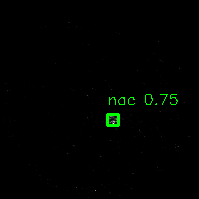


image 1/1 C:\Users\alexi\dataset_yolo\images\test\nac\img_326.png: 256x256 1 nac, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 256)


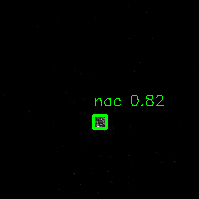


📷 Προβολή προβλέψεων για: GEN

image 1/1 C:\Users\alexi\dataset_yolo\images\test\gen\img_164_GEN.png: 256x256 1 nac, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 2.4ms postprocess per image at shape (1, 3, 256, 256)


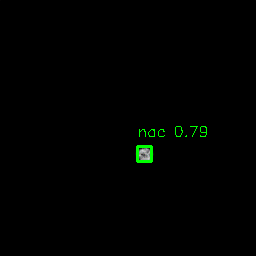


image 1/1 C:\Users\alexi\dataset_yolo\images\test\gen\img_326_GEN.png: 256x256 1 nac, 10.3ms
Speed: 0.9ms preprocess, 10.3ms inference, 2.3ms postprocess per image at shape (1, 3, 256, 256)


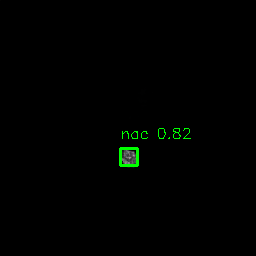

KeyError: "None of ['Dataset'] are in the columns"

In [ ]:
# -*- coding: utf-8 -*-
"""
YOLOv8 Evaluation and Reporting Script (Inline Visualization)
- Select 2 NAC and corresponding 2 generated images for visual comparison
- Run predictions and display annotated images
- Show comparative plots and metrics within the notebook
"""
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from ultralytics import YOLO
from IPython.display import display, Image as IPImage
from PIL import Image
import io

# Define dataset paths
base_dir = Path("dataset_yolo")
nac_test_dir = base_dir / "images/test/nac"
gen_test_dir = base_dir / "images/test/gen"

# Load best-trained model
model = YOLO("runs/train/exp18/weights/best.pt")  # update path if needed

# Collect matching sample pairs (up to 2)
nac_samples = []
gen_samples = []
for img_path in sorted(nac_test_dir.glob("*.png")):
    gen_name = f"{img_path.stem}_GEN.png"
    gen_path = gen_test_dir / gen_name
    if gen_path.exists():
        nac_samples.append(img_path)
        gen_samples.append(gen_path)
    if len(nac_samples) == 2:
        break

# Function to display predictions inline
def show_predictions(image_paths, prefix):
    print(f"\nDisplaying predictions for: {prefix}")
    for img_path in image_paths:
        results = model(str(img_path))[0]
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Warning: Image not found at {img_path}")
            continue
        # Draw bounding boxes and labels
        for box in results.boxes.data.tolist():
            x1, y1, x2, y2, score, cls = box
            coords = map(int, (x1, y1, x2, y2))
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                img,
                f"{model.names[int(cls)]} {score:.2f}",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                1
            )
        # Convert to RGB for display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img_rgb)
        buf = io.BytesIO()
        pil_img.save(buf, format='PNG')
        display(IPImage(data=buf.getvalue()))

# Display predictions for both sets
show_predictions(nac_samples, "NAC")
show_predictions(gen_samples, "Generated")

# Load metrics CSV if available
metrics_csv = Path("comparison_metrics.csv")
if metrics_csv.exists():
    df = pd.read_csv(metrics_csv)
    df.columns = [col.strip() for col in df.columns]
    # Normalize dataset column name
    if 'Dataset' not in df.columns:
        for col in df.columns:
            if 'test' in col.lower() or 'train' in col.lower():
                df.rename(columns={col: 'Dataset'}, inplace=True)
    # Plot mAP50 and mAP50-95 comparisons
    df.set_index("Dataset")[['mAP@50', 'mAP@50-95']].plot(
        kind='bar', figsize=(10, 6)
    )
    plt.title("Mean Average Precision Comparison")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot Precision and Recall
    df.set_index("Dataset")[['Precision', 'Recall']].plot(
        kind='bar', figsize=(10, 6)
    )
    plt.title("Precision and Recall Comparison")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Comparison metrics file not found: 'comparison_metrics.csv'")


In [ ]:
# -*- coding: utf-8 -*-
"""
YOLOv8 Results Export Script
- Load evaluation metrics and save bar plots
- Run YOLO predictions on 2 NAC-GEN image pairs and save results
"""
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
import cv2
from PIL import Image
import os

# Define paths for metrics CSV and output directory
metrics_csv = Path("comparison_metrics.csv")
results_dir = Path("yolo_results")
results_dir.mkdir(exist_ok=True)

# 1. Load metrics and generate comparison plots
if metrics_csv.exists():
    df = pd.read_csv(metrics_csv)
    df.columns = [col.strip() for col in df.columns]
    # Rename dataset column if necessary
    if 'Dataset' not in df.columns:
        detected = [c for c in df.columns if 'set' in c.lower()]
        if detected:
            df.rename(columns={detected[0]: 'Dataset'}, inplace=True)

    # Plot mAP@50 and mAP@50-95
    plt.figure(figsize=(10, 5))
    df.set_index('Dataset')[['mAP@50', 'mAP@50-95']].plot(kind='bar', title='mAP Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(results_dir / 'map_comparison.png')
    plt.close()

    # Plot Precision and Recall
    plt.figure(figsize=(10, 5))
    df.set_index('Dataset')[['Precision', 'Recall']] \
      .plot(kind='bar', color=['orange', 'green'], title='Precision & Recall')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(results_dir / 'precision_recall_comparison.png')
    plt.close()
else:
    print("⚠️  Metrics file not found: comparison_metrics.csv")

# 2. Prepare YOLO model and sample image pairs
model = YOLO('runs/train/exp18/weights/best.pt')  # update path if needed

nac_dir = Path('dataset_yolo/images/test/nac')
gen_dir = Path('dataset_yolo/images/test/gen')

nac_samples, gen_samples = [], []
for img in sorted(nac_dir.glob('*.png')):
    pair = gen_dir / f"{img.stem}_GEN.png"
    if pair.exists():
        nac_samples.append(img)
        gen_samples.append(pair)
    if len(nac_samples) == 2:
        break

# 3. Function to save YOLO predictions on an image

def save_yolo_prediction(img_path, model, save_path):
    results = model(str(img_path))[0]
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Warning: Image not found at {img_path}")
        return
    # Draw boxes and labels on image
    for box in results.boxes.data.tolist():
        x1, y1, x2, y2, score, cls = box
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{model.names[int(cls)]} {score:.2f}"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv2.imwrite(str(save_path), img)

# 4. Save annotated sample images
print("\n💾 Saving YOLO predictions to yolo_results folder")
for idx, (nac, gen) in enumerate(zip(nac_samples, gen_samples), start=1):
    save_yolo_prediction(nac, model, results_dir / f"sample_{idx}_NAC.png")
    save_yolo_prediction(gen, model, results_dir / f"sample_{idx}_GEN.png")



KeyError: "None of ['Dataset'] are in the columns"

<Figure size 1000x500 with 0 Axes>